### Settings

In [ ]:
# importando as bibliotecas
import os
from dotenv import load_dotenv
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
# carregando argumentos de ambiente do .env
load_dotenv()

True

In [ ]:
# criando conexão com o banco
conn = psycopg2.connect(
    host = os.getenv('DB_HOST'),
    port = os.getenv('DB_PORT'),
    user = os.getenv('DB_USER'),
    password = os.getenv('DB_PWD'),
    database = os.getenv('DB_DATABASE')
)

# importando as bases de dados
athlete_bios = pd.read_sql("select * from bronze.athlete_bios", conn)
athlete_results = pd.read_sql("select * from bronze.athlete_results", conn)

# encerrando conexão com o banco
conn.close()

In [386]:
# filtrando dados
athlete_results = athlete_results[athlete_results["season"] == "Summer"]
athlete_results = athlete_results[athlete_results["discipline"] == "Tennis"]
athlete_results = athlete_results[athlete_results["event"] == "Singles, Men (Olympic)"]

In [387]:
# definindo as colunas a serem utilizadas
athlete_bios = athlete_bios.drop_duplicates(subset="athlete_id")
athlete_bios = athlete_bios[["athlete_id","sex","height_cm","weight_kg","born_year","died_year"]]

# tratando alguns pesos e alturas nulas
athlete_bios[["height_cm", "weight_kg"]] = athlete_bios[["height_cm", "weight_kg"]].fillna(0)
pesos = athlete_bios.groupby(by="weight_kg")["height_cm"].median().reset_index().rename(columns={"height_cm":"height_cm_calculado"})
alturas = athlete_bios.groupby(by="height_cm")["weight_kg"].median().reset_index().rename(columns={"weight_kg":"weight_kg_calculado"})

athlete_bios = athlete_bios.merge(pesos, on="weight_kg", how="left")
athlete_bios = athlete_bios.merge(alturas, on="height_cm", how="left")

athlete_bios["height_cm"] = np.where(athlete_bios["height_cm"] == 0, athlete_bios["height_cm_calculado"], athlete_bios["height_cm"])
athlete_bios["weight_kg"] = np.where(athlete_bios["weight_kg"] == 0, athlete_bios["weight_kg_calculado"], athlete_bios["weight_kg"])

athlete_bios = athlete_bios.drop(columns=["height_cm_calculado","weight_kg_calculado"])
athlete_bios = athlete_bios.drop_duplicates(subset="athlete_id")

# cruzando os dados das bases
athlete_results = athlete_results.merge(athlete_bios, on="athlete_id", how="left")

In [388]:
# criando colunas auxiliares
athlete_results["idade"] = athlete_results["year"].fillna(0).astype(int) - athlete_results["born_year"].fillna(0).astype(int)
athlete_results["ganhou_medalha"] = np.where(athlete_results["medal"].isna(), "Não", "Sim")

# tratandos inconsistências nos dados
mediana_idade = athlete_results["idade"].median() 

athlete_results.loc[athlete_results["born_year"].isna(), "idade"] = mediana_idade

# separando a base de treino da base real
base_treino = athlete_results[athlete_results["place"].isin([1.0, 2.0, 3.0, 4.0, 5.0, 6.0])]
base_treino = base_treino[base_treino["weight_kg"] != 0]
base_treino = base_treino[base_treino["year"] <= 2016]

base_real = athlete_results[athlete_results["weight_kg"] != 0]
base_real = base_real[base_real["year"] > 2016]

### Naive Bayes

In [389]:
# separando a base em previsores e classe
previsores_teste = base_treino[["idade","weight_kg","height_cm"]]
classe_teste = base_treino["ganhou_medalha"]

# transformando os dados previsores categóricos em numéricos
label_encoder = LabelEncoder()

previsores_teste["idade"] = label_encoder.fit_transform(previsores_teste["idade"])
previsores_teste["weight_kg"] = label_encoder.fit_transform(previsores_teste["weight_kg"])
previsores_teste["height_cm"] = label_encoder.fit_transform(previsores_teste["height_cm"])

# realizado o treinamento do algoritmo
naive_athlete = GaussianNB()
naive_athlete.fit(previsores_teste, classe_teste)
naive_athlete

C:\Users\felip\AppData\Local\Temp\ipykernel_12700\521754897.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previsores_teste["idade"] = label_encoder.fit_transform(previsores_teste["idade"])
C:\Users\felip\AppData\Local\Temp\ipykernel_12700\521754897.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previsores_teste["weight_kg"] = label_encoder.fit_transform(previsores_teste["weight_kg"])
C:\Users\felip\AppData\Local\Temp\ipykernel_12700\521754897.py:10: SettingWithCopyWarning: 
A value is trying to b

GaussianNB()

In [390]:
# aplicando o algoritmo em uma base real
previsores_real = base_real[["idade","weight_kg","height_cm"]]

# transformando os dados previsores categóricos em numéricos
label_encoder = LabelEncoder()

previsores_real["idade"] = label_encoder.fit_transform(previsores_real["idade"])
previsores_real["weight_kg"] = label_encoder.fit_transform(previsores_real["weight_kg"])
previsores_real["height_cm"] = label_encoder.fit_transform(previsores_real["height_cm"])

# rodando a previsão
dados_previsores = previsores_real.values.tolist()

previsao = naive_athlete.predict(dados_previsores)

base_real["previsao"] = previsao

C:\Users\felip\AppData\Local\Temp\ipykernel_12700\1760063376.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previsores_real["idade"] = label_encoder.fit_transform(previsores_real["idade"])
C:\Users\felip\AppData\Local\Temp\ipykernel_12700\1760063376.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  previsores_real["weight_kg"] = label_encoder.fit_transform(previsores_real["weight_kg"])
C:\Users\felip\AppData\Local\Temp\ipykernel_12700\1760063376.py:9: SettingWithCopyWarning: 
A value is trying to be 

In [391]:
base_real["comparativo"] = base_real["ganhou_medalha"] == base_real["previsao"]
total_registros = base_real.count()[0]
registros_corretos = base_real[base_real["comparativo"] == True].count()[0]

percentual_acerto = registros_corretos / total_registros
percentual_acerto

C:\Users\felip\AppData\Local\Temp\ipykernel_12700\1066202739.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_registros = base_real.count()[0]
C:\Users\felip\AppData\Local\Temp\ipykernel_12700\1066202739.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  registros_corretos = base_real[base_real["comparativo"] == True].count()[0]


0.9210526315789473

In [ ]:
acuracia = accuracy_score(base_real["ganhou_medalha"], base_real["previsao"])
print(f"Acurácia: {acuracia:.2f}")

In [ ]:
# Construindo a matriz de confusão
matriz_confusao = confusion_matrix(base_real["ganhou_medalha"], base_real["previsao"], labels=["Sim", "Não"])

# Exibindo a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues", xticklabels=["Sim", "Não"], yticklabels=["Sim", "Não"])
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

### Árvore de Decisão

In [392]:
# árvore de decisão
arvore_decisao = DecisionTreeClassifier(criterion="entropy")
arvore_decisao.fit(previsores_teste, classe_teste)

DecisionTreeClassifier(criterion='entropy')

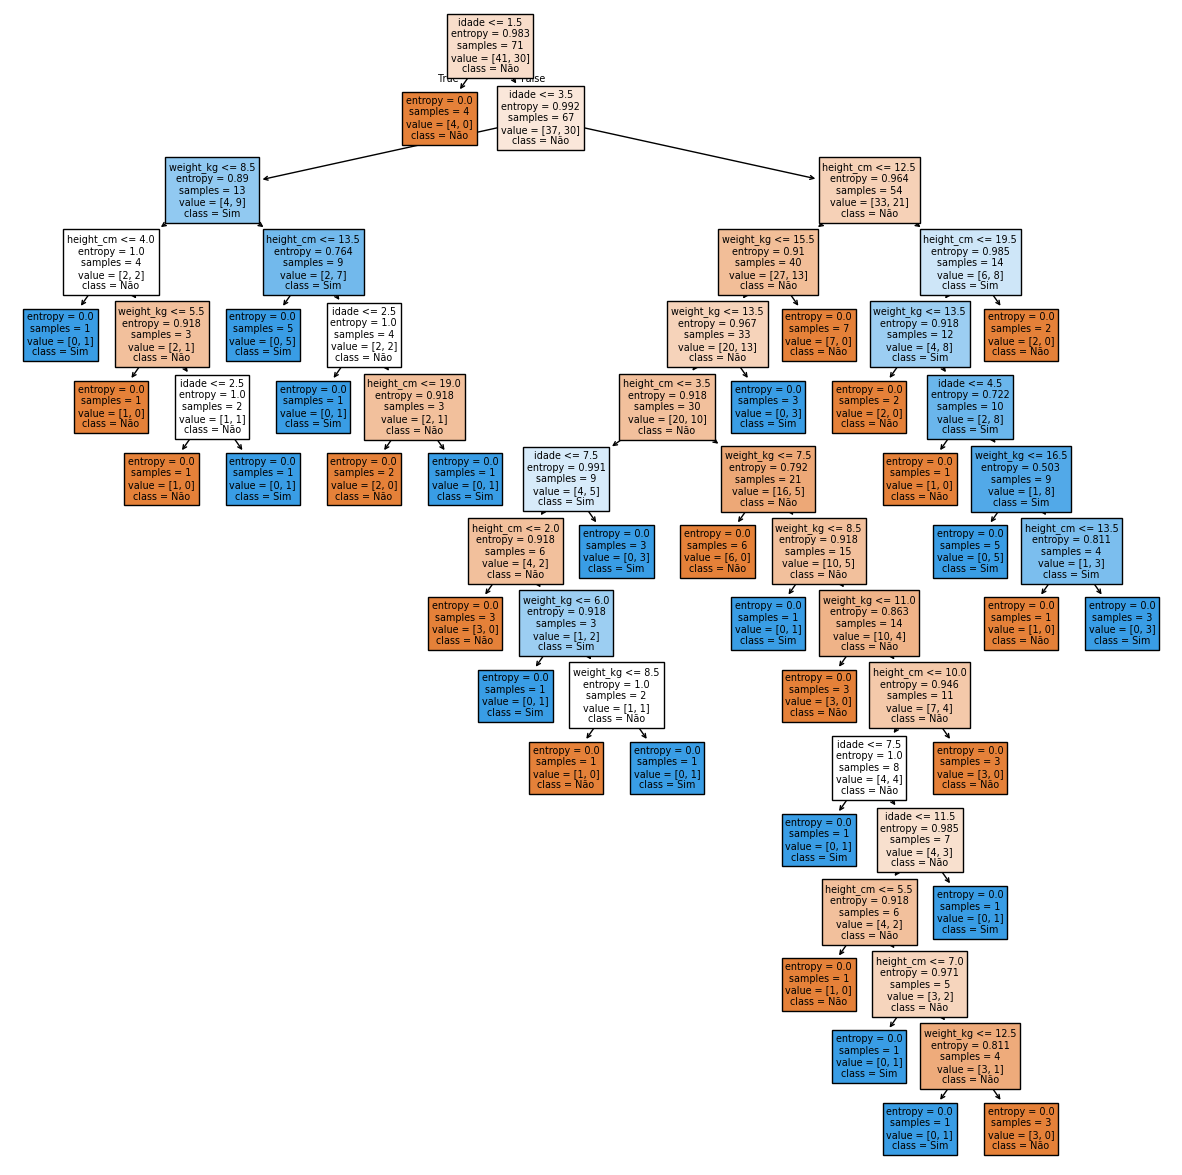

In [393]:
previsores_nomes = arvore_decisao.feature_names_in_
figura, eixos = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
tree.plot_tree(arvore_decisao, feature_names=previsores_nomes, class_names=arvore_decisao.classes_, filled=True);

In [394]:
previsao_arvore_decisao = arvore_decisao.predict(dados_previsores)
base_real["previsao_arvore_decisao"] = previsao_arvore_decisao
base_real["comparativo_arvore_decisao"] = base_real["ganhou_medalha"] == base_real["previsao_arvore_decisao"]

total_registros = base_real.count()[0]
registros_corretos_arvore = base_real[base_real["comparativo_arvore_decisao"] == True].count()[0]

percentual_acerto_arvore = registros_corretos_arvore / total_registros
percentual_acerto_arvore

c:\Users\felip\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\felip\AppData\Local\Temp\ipykernel_12700\2771856367.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_registros = base_real.count()[0]
C:\Users\felip\AppData\Local\Temp\ipykernel_12700\2771856367.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  registros_corretos_arvore = base_real[base_real["comparativo_arvore_decisao"] == True].count()[0]


0.5263157894736842